# Simple is better than complex. Конкурс красоты кода от Сбера

## Описание проекта

**Цель**

Построить наилучшую модель, которая на основании размеченных данных будет предсказывать качество пароля, введенного пользователем.

**Данные**

Данные состоят из примеров паролей и их оценок:
- 0 (слабый)
- 1 (средний)
- 2 (сильный)

**Дополнительные требования**

- Предусмотреть возможность проверки новых паролей.
- Прокомментировать и обосновать преобразования данных, выбор метода и метрики для оценивания результата предсказания модели.


## Модули

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score, 
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

In [2]:
plt.style.use('fivethirtyeight')
RANDOM_STATE = 7

DATA = 'passwords.csv'

## Данные

In [3]:
data = pd.read_csv(DATA)
data.info()
data.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  100000 non-null  object
 1   strength  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


,password,strength
47394,9h7t7a26,1
53808,tangerina2,1


- пропусков нет
- удаляем пробелы в начале и в конце паролей, обычно они не учитываются
- проверяем дубликаты и убираем их

In [4]:
data.password = data.password.str.strip()
dup_sum = data.password.duplicated().sum()
if dup_sum>0:
    print(f'Найдены дубликаты паролей {dup_sum} шт, удаляем')
    data = data.drop_duplicates(subset='password')
print('проверка – дубликаты паролей', data.password.duplicated().sum())

Найдены дубликаты паролей 1 шт, удаляем
проверка – дубликаты паролей 0


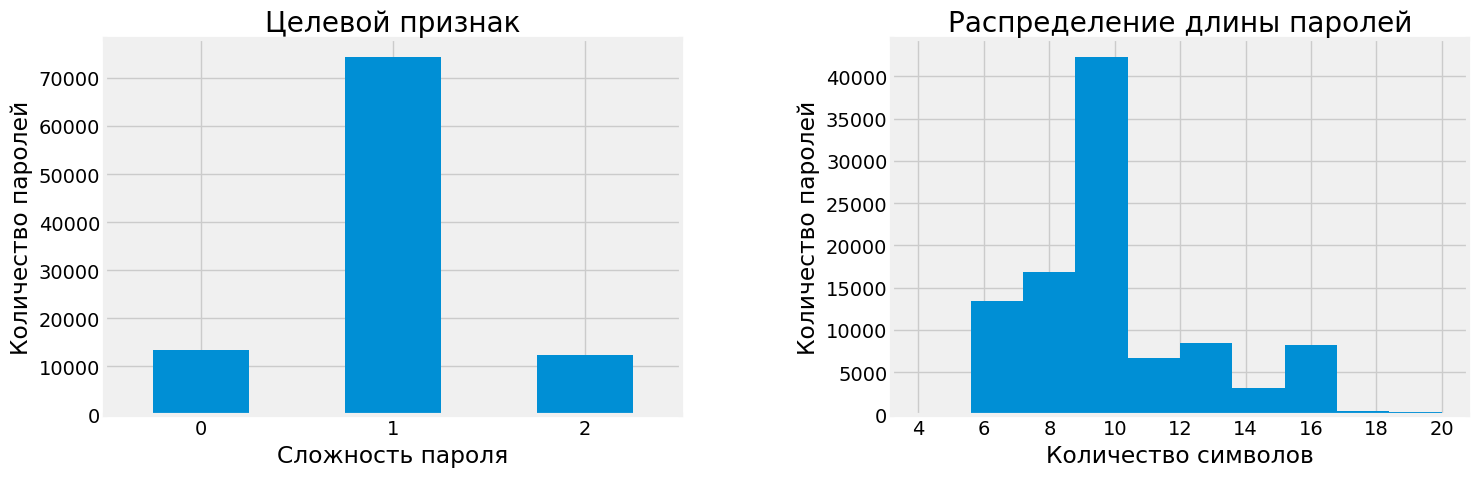

In [5]:
fig = plt.figure(figsize=(15,5), facecolor='white')
fig.add_subplot(1,2,1)
ylabel = 'Количество паролей'
data.strength.sort_values().value_counts(sort=False).plot(kind='bar')
plt.title('Целевой признак')
plt.xlabel('Сложность пароля')
plt.ylabel(ylabel)
plt.xticks(rotation=0)
fig.add_subplot(1,2,2)
plt.title('Распределение длины паролей')
data.password.str.len().hist(bins=10, range=(4, 20))
plt.xlabel('Количество символов')
plt.ylabel(ylabel)
plt.tight_layout(w_pad=6)
plt.show()

In [6]:
all_charset = sorted(set(list(''.join(data.password.tolist()))))
print('Количество разнообразных символов', len(all_charset))
print('Все символы', ''.join(all_charset))

Количество разнообразных символов 111
Все символы  !"#$%&()*+-./0123456789;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_abcdefghijklmnopqrstuvwxyz{|}~«±³´·»ÄÏÑÔÚÝÞáúþƒ‡


В представленном датасете
- пропусков нет
- найден и удален один дубликат
- сложности паролей представлены шкалой от 0 до 2
- основная масса паролей имеет среднюю сложность 1
- наибольшее количество паролей имеет длину 9-10 символов
- всего найдено 111 разных символов
    - весь латинский алфавит в верхнем и нижнем регистре
    - буквы с акцентами
    - все цифры
    - математические и служебные символы
    - пара странных знаков, которые не отобразились нормально

## Признаки
- Добавим дополнительный признак – длину пароля
- Создадим список признаков для обучения

In [7]:
data = data.assign(length=data.password.str.len())
features = ['password', 'length']

## Обучение

Эту задачу можно решать как многоклассовую классификацию или как регрессию.

Выберем вариант с регрессией:
- Оценка пароля представляет собой числовую шкалу от 0 до 2 по нарастанию сложности
- Метрику используем RMSE, с ней выбросы будут заметнее
- Пароли векторизуем посимвольно с помощью TF-IDF и добавим n-граммы от 1 до 2 знаков
- Модель XGB Regressor
- Валидация и тестирование
    - выделим тестовый набор данных 25%
    - добавим параметр `stratify` по таргету `strength`, чтобы сбалансировать выборки
    - проверим качество модели на кросс-валидации
    - проведем итоговое тестирование

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data.strength, 
    test_size=0.25, 
    stratify=data.strength, 
    random_state=RANDOM_STATE
)

In [9]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), ['length']),
    ('char', TfidfVectorizer(analyzer='char', 
                             lowercase=False, 
                             ngram_range=(1,2)
                            ), 'password')
])

pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBRegressor(random_state=RANDOM_STATE,
                           n_estimators=50,
                           n_jobs=-1))
])

In [10]:
cv = cross_val_score(pipe, X_train, y_train, 
                     scoring='neg_root_mean_squared_error', 
                     n_jobs=-1, 
                     cv=3)
print('RMSE по фолдам', -cv.round(2))
print('Среднее RMSE', -cv.mean().round(2))

RMSE по фолдам [0.   0.01 0.01]
Среднее RMSE 0.0


## Тестирование

In [11]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE на тесте', rmse.round(2))

RMSE на тесте 0.0


## Функция для проверки новых паролей

Создадим функцию для проверки сложности пароля
- на вход можно подавать список, массив, серию, число или строку
- возвращает массив со сложностью паролей, точность два знака после запятой

In [12]:
def check_password(password, model=pipe) -> np.ndarray:
    '''
    password: пароли списком, массивом, серией пандас, числом или строкой
    model: по умолчанию передаем pipe обученный выше
    '''
    
    password_type = type(password).__name__
    if password_type in ('list', 'ndarray', 'Series'):
        idx = range(len(password))
    elif password_type in ('str', 'int', 'float'):
        idx = [0]
    else:
        raise Exception(f'Тип пароля {password_type} не поддерживается')
        
    X = pd.DataFrame(
        {'password': password},
        index=idx
    )
    X.password = X.password.astype(str)
    X = X.assign(length=X.password.str.len())
    
    return model.predict(X).round(2)

Проведем испытание функции

In [13]:
test_password = ['kjhyt5$#ER%^&8uikmnb7JNHB', 123.456, 'IKJUHYGFT']
print('Сложность\n', check_password(test_password))

Сложность
 [2. 0. 1.]


## Заключение

В проекте решена задача определения сложности пароля.

Загружен и изучен представленный датасет с паролями:
- пропусков нет
- найден и удален один дубликат
- сложности паролей представлены шкалой от 0 до 2
- основная масса паролей имеет среднюю сложность 1
- наибольшее количество паролей имеет длину 9-10 символов
- всего найдено 111 разных символов
- весь латинский алфавит в верхнем и нижнем регистре
- буквы с акцентами
- все цифры
- математические и служебные символы
- пара странных знаков, которые не отобразились нормально

Во время экспериментов выявлено:
- важным признаком является длина пароля
- хорошим признаком стало добавление биграмм

Результат:
- создан пайплайн:
    - масштабирование числового признака длины пароля
    - посимвольная векторизация TF-IDF пароля с биграммами
    - модель регрессии XGBRegressor
- ошибка предсказания RMSE 0-0.01
- создана функция для проверки произвольных паролей